In [117]:
# Appendix I - All code used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss

import nltk
from nltk.corpus import stopwords
import string

In [118]:
# Load the dataset
# Can be downloaded at https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset
data = pd.read_csv('train_v2_drcat_02.csv')

In [119]:
# Display structure of the dataset
print("Dataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB
None

Missing Values:
text             0
label            0
prompt_name      0
source           0
RDizzl3_seven    0
dtype: int64


In [120]:
# Examine the data a bit further
print("\nLabel Distribution:")
print(data['label'].value_counts())

# Separate the data into essays generated by AI (label=1) and written by humans (label=0)
human_written = data[data['label'] == 0]
ai_generated = data[data['label'] == 1]

# Display the first few rows of human-written essays
print("\nHuman-written essays:")
print(human_written.head())

# Display the first few rows of AI-generated essays
print("\nAI-generated essays:")
print(ai_generated.head())


Label Distribution:
label
0    27371
1    17497
Name: count, dtype: int64

Human-written essays:
                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

          prompt_name           source  RDizzl3_seven  
0  Phones and driving  persuade_corpus          False  
1  Phones and driving  persuade_corpus          False  
2  Phones and driving  persuade_corpus          False  
3  Phones and driving  persuade_corpus          False  
4  Phones and driving  persuade_corpus          False  

AI-generated essays:
                                                    text  label  \
25996   In recent years, technology has had a profoun...      1   
25997  I strongly believe that 

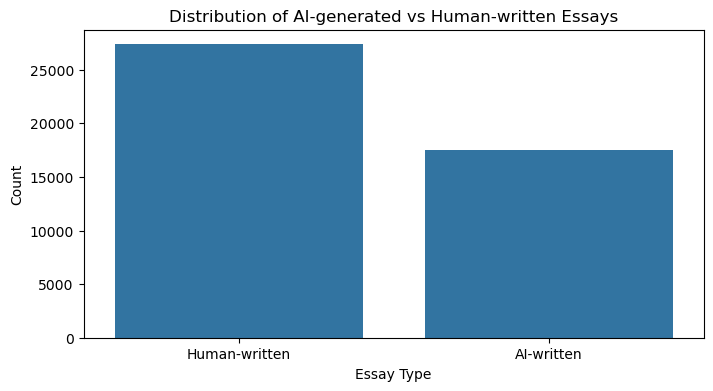

In [121]:
# Plot the number of AI-generated vs human-written essays
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data)
plt.title('Distribution of AI-generated vs Human-written Essays')
plt.xlabel('Essay Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Human-written', 'AI-written'])

plt.show()

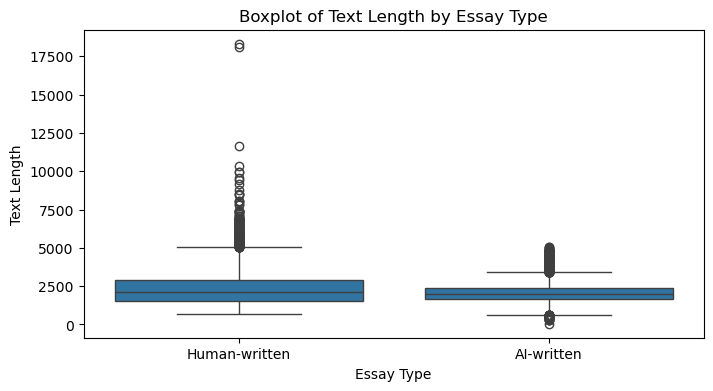

In [122]:
# Additional analysis: length of essays boxplot
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='text_length', data=data)
plt.title('Boxplot of Text Length by Essay Type')
plt.xlabel('Essay Type')
plt.ylabel('Text Length')
plt.xticks(ticks=[0, 1], labels=['Human-written', 'AI-written'])
plt.show()

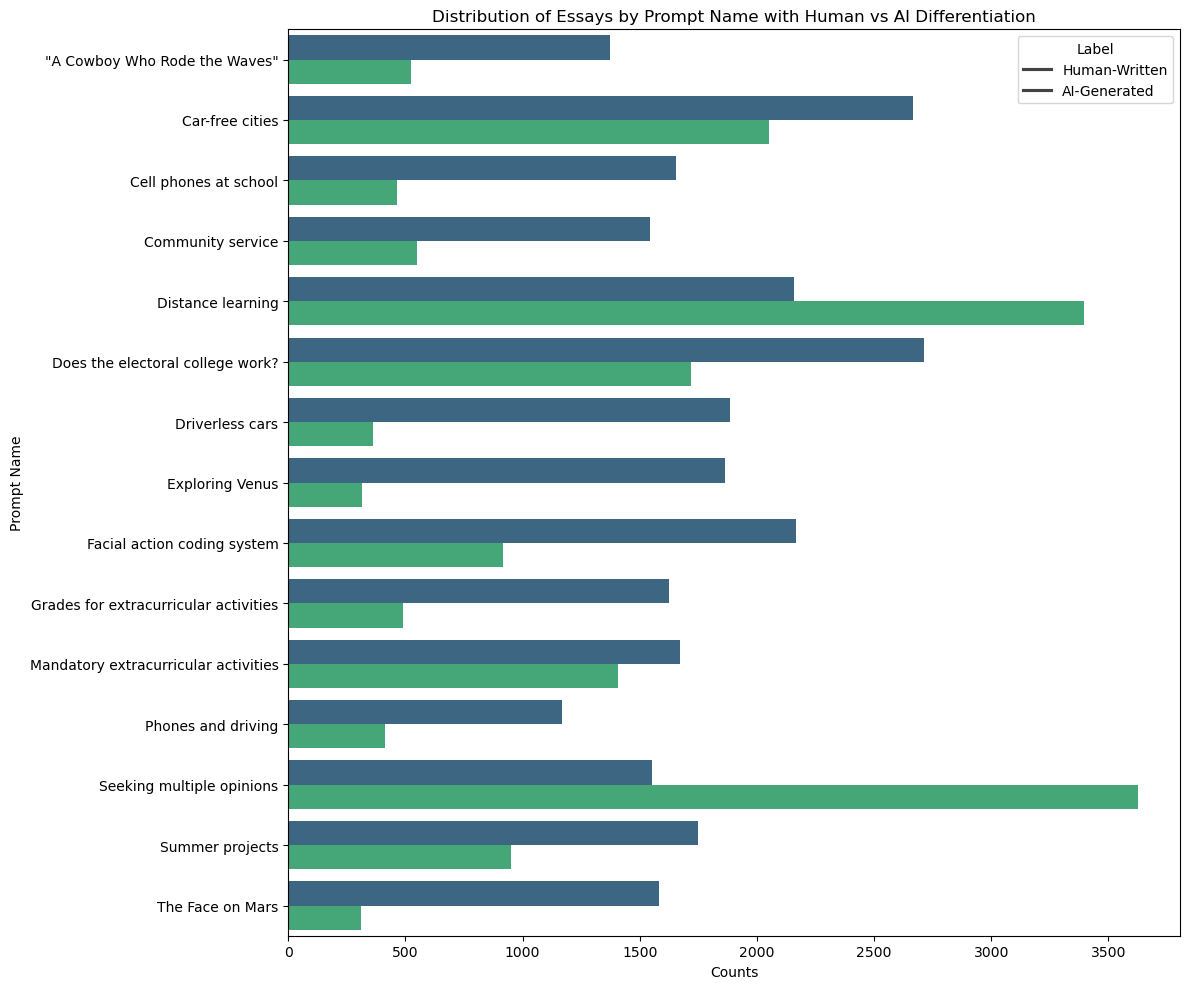

In [123]:
# Group data by 'prompt_name' and 'label', and count occurrences
prompt_label_group = data.groupby(['prompt_name', 'label']).size().reset_index(name='counts')

# Sorting the data by prompt name and counts to better visualize in the plot
prompt_label_sorted = prompt_label_group.sort_values(['prompt_name', 'counts'], ascending=[True, False])

# Plotting the distribution of essays by prompt name, with differentiation between human and AI
plt.figure(figsize=(12, 10))
sns.barplot(x='counts', y='prompt_name', hue='label', data=prompt_label_sorted, palette='viridis')
plt.title('Distribution of Essays by Prompt Name with Human vs AI Differentiation')
plt.xlabel('Counts')
plt.ylabel('Prompt Name')
plt.legend(title='Label', labels=['Human-Written', 'AI-Generated'])
plt.tight_layout() 
plt.show()

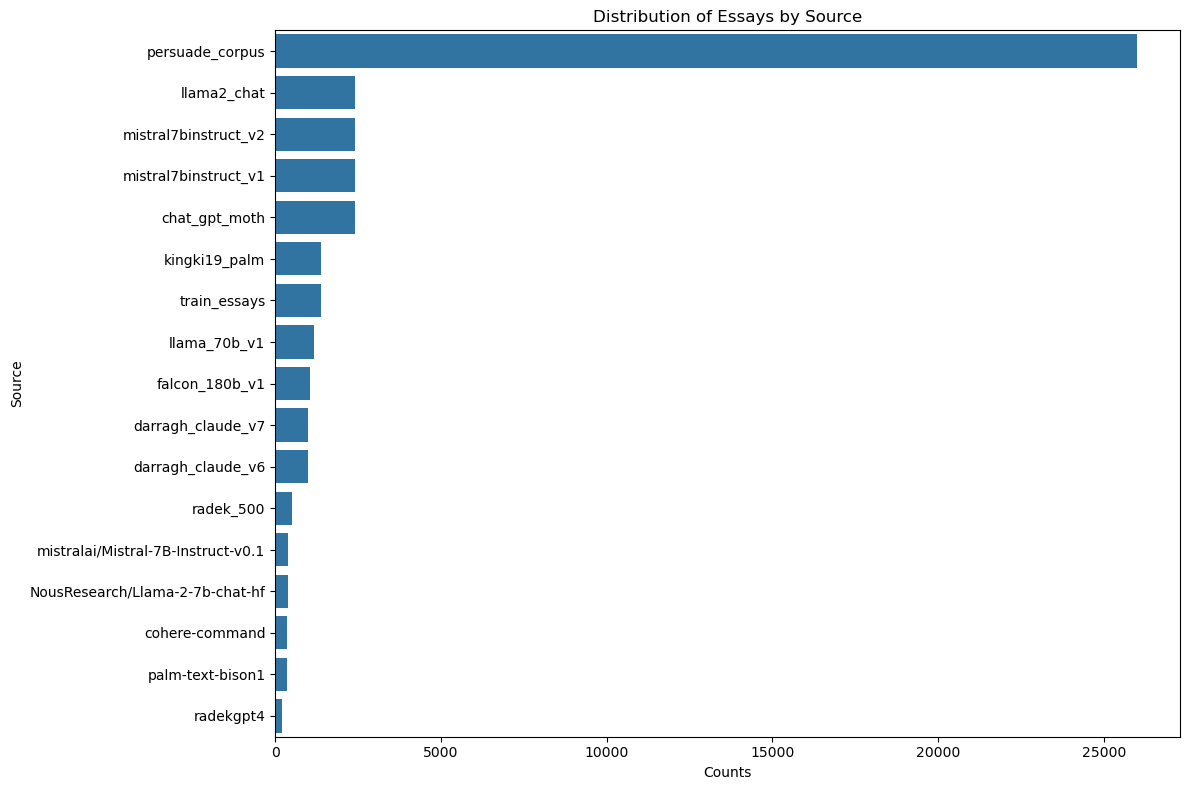

In [124]:
# Group data by 'source' and count occurrences
source_group = data.groupby('source').size().reset_index(name='counts')

# Sort the data by counts before plotting
source_sorted = source_group.sort_values('counts', ascending=False)

# Plotting the distribution of essays by source
plt.figure(figsize=(12, 8))
sns.barplot(x='counts', y='source', data=source_sorted)
plt.title('Distribution of Essays by Source')
plt.xlabel('Counts')
plt.ylabel('Source')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

In [125]:
# Ensure 'label' column is in the dataset
assert 'label' in data.columns, "The dataset does not contain a 'label' column."

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Display the shape of the training and validation sets
print(f'Training set shape: {train_data.shape}')
print(f'Validation set shape: {val_data.shape}')


Training set shape: (35894, 6)
Validation set shape: (8974, 6)


In [126]:
print(data.columns)
data.head()

Index(['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven',
       'text_length'],
      dtype='object')


,text,label,prompt_name,source,RDizzl3_seven,text_length
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,2029
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,2141
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,1044
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,1243
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,1911


In [127]:
#nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

# Stopwords preprocessing 
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

# Apply the preprocessing to the essay texts
train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)

In [128]:
# Vectorize the essays using TF-IDF, added to improve logistic regression performance only
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data['text'])
X_val = vectorizer.transform(val_data['text'])

# Labels
y_train = train_data['label']
y_val = val_data['label']

In [129]:
# Show sample data that have stopwords removed
train_data['text'] 

5233     Luke seems like program help people countriesy...
28816    One strategy business increasingly adopting co...
1550     Imagine youre populated city Lets say New York...
1888     People tend use cars much basically cant live ...
16987    Driveless cars great enhancement futures socie...
                               ...                        
11284    believe using technology could effective class...
44732    Dear Senator writing today express support abo...
38158    Despite many hurdles must face attempting achi...
860      Texting Driving Using phone driving worse comb...
15795    Dear Principal really good quarter students wo...
Name: text, Length: 35894, dtype: object

In [140]:
# Note below shows TOKENIZED and not VECTORIZED X-train (which will be sparse)
X_train

array([[   0,    0,    0, ...,    7,  513,   66],
       [   0,    0,    0, ...,  606, 3048,  823],
       [5293,  258,  948, ...,  290,  223, 1697],
       ...,
       [   0,    0,    0, ...,  214,  137,   20],
       [ 167,  433,  128, ...,   56, 2511,   10],
       [   0,    0,    0, ...,  466,  135,  273]], dtype=int32)

In [131]:
# Preprocessing and data exploration complete. Below is model related code

In [141]:
# A simple logistic regression classifier as benchmark
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf.predict(X_val)

# Evaluate the classifier
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.6405
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.89      0.75      5481
           1       0.59      0.24      0.35      3493

    accuracy                           0.64      8974
   macro avg       0.62      0.57      0.55      8974
weighted avg       0.63      0.64      0.59      8974



In [137]:
# Setting up LSTM Model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_features = 10000
maxlen = 150 

# Tokenize the text for LSTM
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['text'])

X_train = tokenizer.texts_to_sequences(train_data['text'])
X_val = tokenizer.texts_to_sequences(val_data['text'])

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)


In [87]:
# Building and Training the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5


2024-08-07 01:03:09.116043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 01:03:09.116487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 01:03:09.116987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1122/1122 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9723

2024-08-07 01:04:24.304839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 01:04:24.305441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 01:04:24.305776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1122/1122 [==============================] - 80s 71ms/step - loss: 0.0783 - accuracy: 0.9723 - val_loss: 0.0312 - val_accuracy: 0.9910
Epoch 2/5
1122/1122 [==============================] - 81s 72ms/step - loss: 0.0239 - accuracy: 0.9935 - val_loss: 0.0340 - val_accuracy: 0.9910
Epoch 3/5
1122/1122 [==============================] - 82s 73ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.0372 - val_accuracy: 0.9887
Epoch 4/5
1122/1122 [==============================] - 83s 74ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0435 - val_accuracy: 0.9890
Epoch 5/5
1122/1122 [==============================] - 83s 74ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0541 - val_accuracy: 0.9876


In [88]:
# Save the LSTM model
model.save('lstm_model.h5')

In [89]:
# Predict on the validation set
y_pred_lstm = model.predict(X_val)
y_pred_lstm = (y_pred_lstm > 0.5).astype("int32")

# Evaluate the classifier
accuracy_lstm = accuracy_score(y_val, y_pred_lstm)
print(f'LSTM Validation Accuracy: {accuracy_lstm:.4f}')
print('LSTM Classification Report:')
print(classification_report(y_val, y_pred_lstm))

  4/281 [..............................] - ETA: 4s 

2024-08-07 01:09:58.033339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 01:09:58.033803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 01:09:58.034376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - 5s 18ms/step
LSTM Validation Accuracy: 0.9876
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5481
           1       0.98      0.99      0.98      3493

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



In [ ]:
# Note that the Validation accuracies may not be exactly the same as in report given different training runs.

In [90]:
# Building and Training the RNN model
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 128, input_length=maxlen))
model_rnn.add(SimpleRNN(64, return_sequences=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = model_rnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/5
1122/1122 [==============================] - 31s 27ms/step - loss: 0.2073 - accuracy: 0.9185 - val_loss: 0.0750 - val_accuracy: 0.9786
Epoch 2/5
1122/1122 [==============================] - 31s 27ms/step - loss: 0.1802 - accuracy: 0.9220 - val_loss: 0.6251 - val_accuracy: 0.6917
Epoch 3/5
1122/1122 [==============================] - 31s 27ms/step - loss: 0.4263 - accuracy: 0.8068 - val_loss: 0.3852 - val_accuracy: 0.8729
Epoch 4/5
1122/1122 [==============================] - 31s 27ms/step - loss: 0.2789 - accuracy: 0.8930 - val_loss: 0.1506 - val_accuracy: 0.9595
Epoch 5/5
1122/1122 [==============================] - 31s 27ms/step - loss: 0.1387 - accuracy: 0.9579 - val_loss: 0.1192 - val_accuracy: 0.9663


In [91]:
# Predict on the validation set
y_pred_rnn = model_rnn.predict(X_val)
y_pred_rnn = (y_pred_rnn > 0.5).astype("int32")

# Evaluate the classifier
accuracy_rnn = accuracy_score(y_val, y_pred_rnn)
print(f'RNN Validation Accuracy: {accuracy_rnn:.4f}')
print('RNN Classification Report:')
print(classification_report(y_val, y_pred_rnn))


281/281 [==============================] - 2s 6ms/step
RNN Validation Accuracy: 0.9663
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5481
           1       0.97      0.94      0.96      3493

    accuracy                           0.97      8974
   macro avg       0.97      0.96      0.96      8974
weighted avg       0.97      0.97      0.97      8974



In [92]:
# Save the rnn model
model_rnn.save('rnn_model.h5')

In [93]:
# Extract LSTM and RNN training history
lstm_history = {
    'loss': lstm_history.history['loss'],
    'val_loss': lstm_history.history['val_loss'],
    'accuracy': lstm_history.history['accuracy'],
    'val_accuracy': lstm_history.history['val_accuracy']
}

rnn_history = {
    'loss': rnn_history.history['loss'],
    'val_loss': rnn_history.history['val_loss'],
    'accuracy': rnn_history.history['accuracy'],
    'val_accuracy': rnn_history.history['val_accuracy']
}

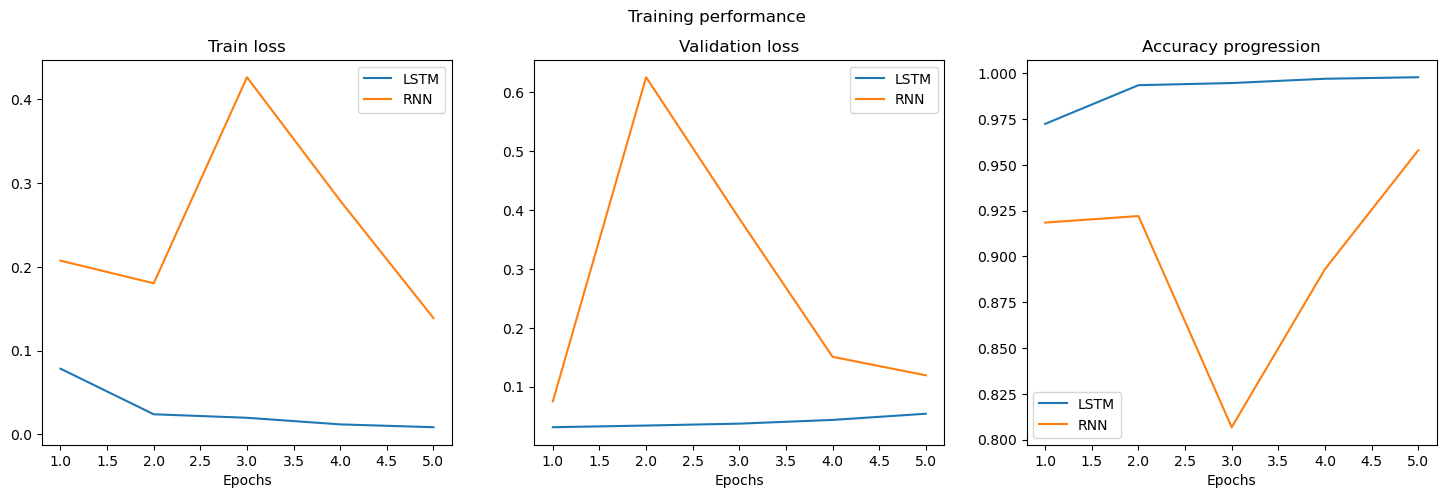

In [94]:
# Function to plot both histories on a single plots
def plot_training_history(histories, titles, steps):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    for history, title, step in zip(histories, titles, steps):
        epochs = range(1, len(history['loss']) + 1)
        axs[0].plot(epochs, history['loss'], label=title)
        axs[1].plot(epochs, history['val_loss'], label=title)
        axs[2].plot(epochs, history['accuracy'], label=title)
    
    axs[0].set_title('Train loss')
    axs[1].set_title('Validation loss')
    axs[2].set_title('Accuracy progression')
    for ax in axs:
        ax.legend()
        ax.set_xlabel('Epochs')

    plt.suptitle('Training performance')
    plt.show()

histories = [lstm_history, rnn_history]
titles = ['LSTM', 'RNN']
steps = [step, 1, 1]  # steps used for plotting epochs

# Plot the histories
plot_training_history(histories, titles, steps)

In [95]:
# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

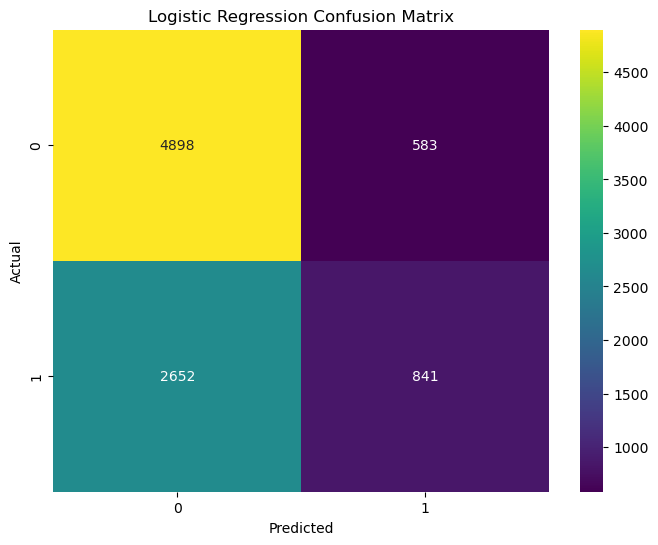

In [96]:
# Logistic Regression
plot_confusion_matrix(y_val, y_pred_logistic, 'Logistic Regression Confusion Matrix')

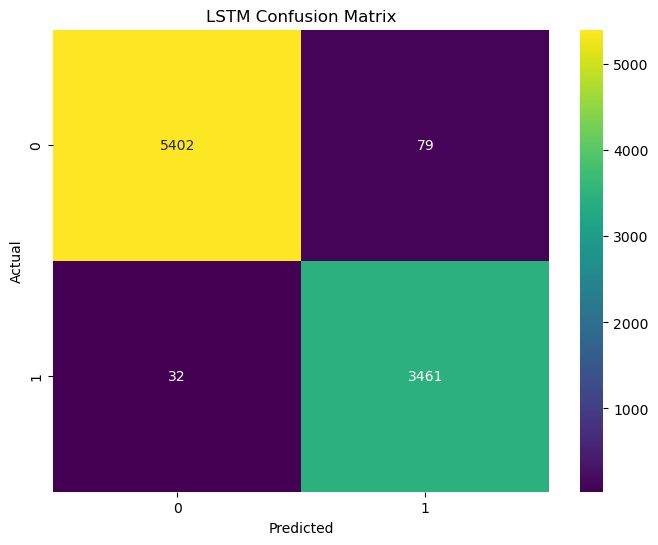

In [97]:
# LSTM
y_pred_lstm = (y_pred_lstm > 0.5).astype("int32").flatten()
plot_confusion_matrix(y_val, y_pred_lstm, 'LSTM Confusion Matrix')

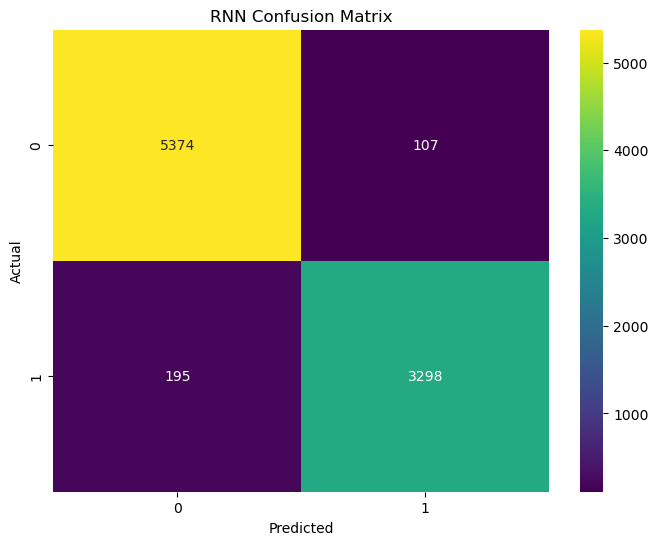

In [98]:
# RNN
y_pred_rnn = (y_pred_rnn > 0.5).astype("int32").flatten()
plot_confusion_matrix(y_val, y_pred_rnn, 'RNN Confusion Matrix')

In [153]:
# Accuracy Breakdown Analysis by Prompt Name

# Add predictions to validation data
val_data['y_pred_lstm'] = y_pred_lstm
val_data['y_pred_rnn'] = y_pred_rnn

# Group by prompt name and calculate accuracy
prompt_accuracy_lstm = val_data.groupby('prompt_name').apply(lambda x: accuracy_score(x['label'], x['y_pred_lstm']))
prompt_accuracy_rnn = val_data.groupby('prompt_name').apply(lambda x: accuracy_score(x['label'], x['y_pred_rnn']))

print('LSTM Accuracy by Prompt Name:')
print(prompt_accuracy_lstm)

print('\n')

print('RNN Accuracy by Prompt Name:')
print(prompt_accuracy_rnn)


LSTM Accuracy by Prompt Name:
prompt_name
"A Cowboy Who Rode the Waves"            0.986450
Car-free cities                          0.997967
Cell phones at school                    0.995349
Community service                        0.981609
Distance learning                        0.980072
Does the electoral college work?         0.994246
Driverless cars                          0.986755
Exploring Venus                          0.997658
Facial action coding system              0.994718
Grades for extracurricular activities    0.980998
Mandatory extracurricular activities     0.970497
Phones and driving                       0.993884
Seeking multiple opinions                0.984344
Summer projects                          0.985612
The Face on Mars                         0.989041
dtype: float64


RNN Accuracy by Prompt Name:
prompt_name
"A Cowboy Who Rode the Waves"            0.972900
Car-free cities                          0.972561
Cell phones at school                    0.969767


/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_92515/1772376208.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prompt_accuracy_lstm = val_data.groupby('prompt_name').apply(lambda x: accuracy_score(x['label'], x['y_pred_lstm']))
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_92515/1772376208.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prompt_accuracy_rnn = val_data.groupb

In [154]:
# Group by source and calculate accuracy
source_accuracy_lstm = val_data.groupby('source').apply(lambda x: accuracy_score(x['label'], x['y_pred_lstm']))
source_accuracy_rnn = val_data.groupby('source').apply(lambda x: accuracy_score(x['label'], x['y_pred_rnn']))
include_groups=False
print('LSTM Accuracy by Source:')
print(source_accuracy_lstm)

print('\n')

print('RNN Accuracy by Source:')
print(source_accuracy_rnn)

LSTM Accuracy by Source:
source
NousResearch/Llama-2-7b-chat-hf       1.000000
chat_gpt_moth                         0.995772
cohere-command                        0.915493
darragh_claude_v6                     1.000000
darragh_claude_v7                     1.000000
falcon_180b_v1                        1.000000
kingki19_palm                         1.000000
llama2_chat                           0.998004
llama_70b_v1                          0.982456
mistral7binstruct_v1                  0.993644
mistral7binstruct_v2                  0.968064
mistralai/Mistral-7B-Instruct-v0.1    1.000000
palm-text-bison1                      1.000000
persuade_corpus                       0.985563
radek_500                             1.000000
radekgpt4                             1.000000
train_essays                          0.986014
dtype: float64


RNN Accuracy by Source:
source
NousResearch/Llama-2-7b-chat-hf       0.970588
chat_gpt_moth                         0.947146
cohere-command             

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_92515/308316122.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  source_accuracy_lstm = val_data.groupby('source').apply(lambda x: accuracy_score(x['label'], x['y_pred_lstm']))
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_92515/308316122.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  source_accuracy_rnn = val_data.groupby('sour

In [155]:
# Calculate error rate (1 - accuracy)
prompt_error_lstm = 1 - prompt_accuracy_lstm
prompt_error_rnn = 1 - prompt_accuracy_rnn

# Convert the error data to DataFrames
prompt_error_lstm_df = prompt_error_lstm.reset_index()
prompt_error_rnn_df = prompt_error_rnn.reset_index()

# Rename the error column to 'error_rate'
prompt_error_lstm_df.columns = ['prompt_name', 'error_rate']
prompt_error_rnn_df.columns = ['prompt_name', 'error_rate']

# Print column names to verify
print(prompt_error_lstm_df.columns)
print(prompt_error_rnn_df.columns)

Index(['prompt_name', 'error_rate'], dtype='object')
Index(['prompt_name', 'error_rate'], dtype='object')


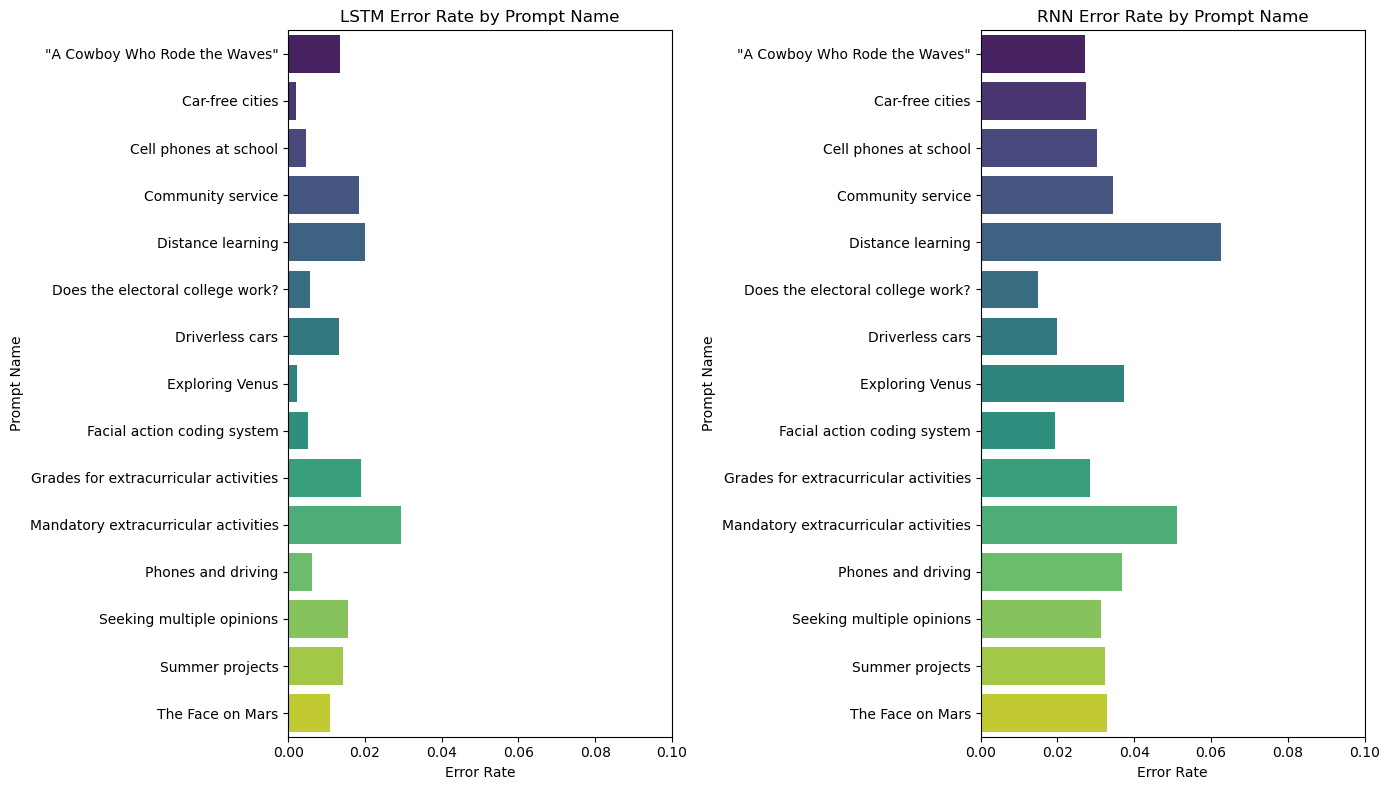

In [163]:
plt.figure(figsize=(14, 8))

# Plot LSTM error rate
plt.subplot(1, 2, 1)
sns.barplot(x='error_rate', y='prompt_name', data=prompt_error_lstm_df, palette='viridis', hue='prompt_name',legend=False)
plt.title('LSTM Error Rate by Prompt Name')
plt.xlabel('Error Rate')
plt.ylabel('Prompt Name')
plt.xlim(0, 0.1)  # Set x-axis limit to 1 for clarity

# Plot RNN error rate
plt.subplot(1, 2, 2)
sns.barplot(x='error_rate', y='prompt_name', data=prompt_error_rnn_df, palette='viridis', hue='prompt_name',legend=False)
plt.title('RNN Error Rate by Prompt Name')
plt.xlabel('Error Rate')
plt.ylabel('Prompt Name')
plt.xlim(0, 0.1)  # Set x-axis limit to 1 for clarity

# Adjust layout
plt.tight_layout()
plt.show()

In [142]:
# Build the Bidirectional LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(max_features, 128, input_length=maxlen))
model_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Bidirectional(LSTM(64)))
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Dense(1, activation='sigmoid'))

model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bi_lstm_history = model_bi_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))


2024-08-07 12:01:20.888693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 12:01:20.889163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 12:01:20.889705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2024-08-07 12:01:21.325714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-08-07 12:01:21.339189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 12:01:21.339619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

1122/1122 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9689

2024-08-07 12:02:58.481159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 12:02:58.481677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 12:02:58.482053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1122/1122 [==============================] - 104s 91ms/step - loss: 0.0916 - accuracy: 0.9689 - val_loss: 0.0560 - val_accuracy: 0.9837
Epoch 2/5
1122/1122 [==============================] - 102s 91ms/step - loss: 0.0357 - accuracy: 0.9904 - val_loss: 0.0532 - val_accuracy: 0.9824
Epoch 3/5
1122/1122 [==============================] - 102s 91ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.0336 - val_accuracy: 0.9899
Epoch 4/5
1122/1122 [==============================] - 102s 91ms/step - loss: 0.0150 - accuracy: 0.9960 - val_loss: 0.0485 - val_accuracy: 0.9873
Epoch 5/5
1122/1122 [==============================] - 101s 90ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.0436 - val_accuracy: 0.9899


In [143]:
# Make predictions on the validation set
y_pred_bi_lstm= (model_bi_lstm.predict(X_val) > 0.5).astype("int32")

# Calculate accuracy
bi_lstm_accuracy = accuracy_score(y_val, y_pred_bi_lstm)
print(f'Bidirectional LSTM Validation Accuracy: {bi_lstm_accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(y_val, y_pred_bi_lstm))

2024-08-07 12:09:51.868288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 12:09:51.868755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 12:09:51.869353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - 7s 22ms/step
Bidirectional LSTM Validation Accuracy: 0.9899
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5481
           1       0.99      0.98      0.99      3493

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



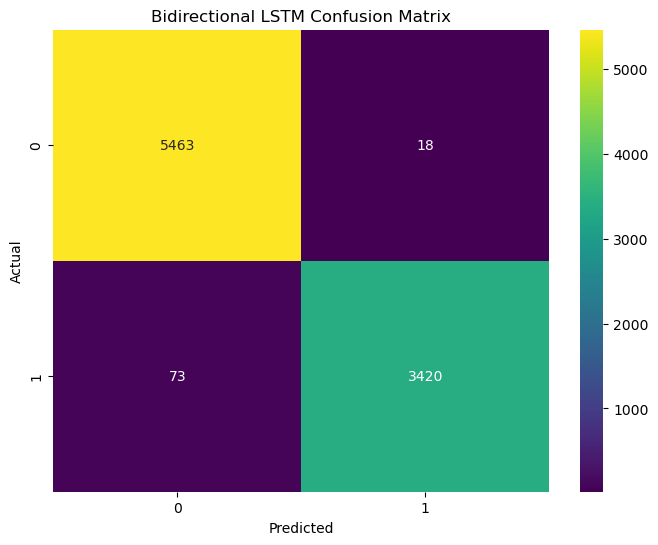

In [144]:
# Confusion matrix
y_pred_bi_lstm = (y_pred_bi_lstm > 0.5).astype("int32").flatten()
plot_confusion_matrix(y_val, y_pred_bi_lstm, 'Bidirectional LSTM Confusion Matrix')

In [165]:
# Save the Bidirectional LSTM
model_bi_lstm.save('bi_lstm_model.h5')

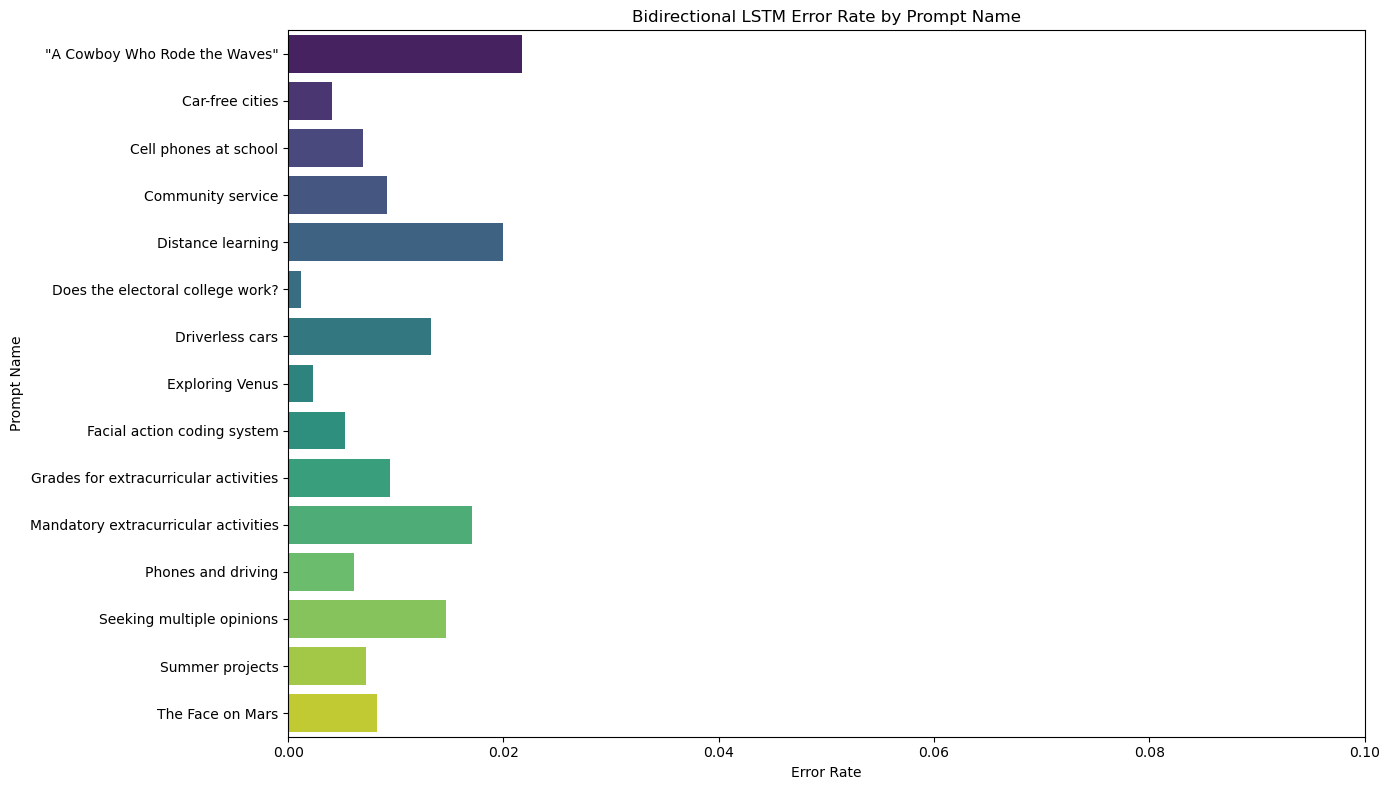

In [164]:
# Group by prompt name and calculate accuracy
val_data['y_pred_bi_lstm'] = y_pred_bi_lstm
prompt_accuracy_bi_lstm = val_data.groupby('prompt_name').apply(lambda x: accuracy_score(x['label'], x['y_pred_bi_lstm']),include_groups=False)

# Calculate error rate (1 - accuracy)
prompt_error_bi_lstm = 1 - prompt_accuracy_bi_lstm

# Convert the error data to DataFrame
prompt_error_bi_lstm_df = prompt_error_bi_lstm.reset_index()
prompt_error_bi_lstm_df.columns = ['prompt_name', 'error_rate']

# Plot the error rates
plt.figure(figsize=(14, 8))

# Plot Bidirectional RNN error rate
sns.barplot(x='error_rate', y='prompt_name', data=prompt_error_bi_lstm_df, palette='viridis', hue='prompt_name')
plt.title('Bidirectional LSTM Error Rate by Prompt Name')
plt.xlabel('Error Rate')
plt.ylabel('Prompt Name')
plt.xlim(0, 0.1)  # Set x-axis limit to 1 for clarity

# Adjust layout
plt.tight_layout()
plt.show()